# Regression: Linear

## References

1. Schlimmer,Jeffrey. (1987). Automobile. UCI Machine Learning Repository. https://doi.org/10.24432/C5B01C.
2. https://www.kaggle.com/datasets/hellbuoy/car-price-prediction

## Import Python Libraries

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import boxcox, boxcox_normplot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error, mean_absolute_error, median_absolute_error

## Global Variables

In [39]:
# random state seed for repeatability
random_state = 4781

# colors
c1 = 'grey'
c2 = 'red'
c3 = 'blue'

## Import Dataset

In [40]:

# Source: 
# 1. Schlimmer,Jeffrey. (1987). Automobile. UCI Machine Learning Repository. https://doi.org/10.24432/C5B01C.
# 2. https://www.kaggle.com/datasets/hellbuoy/car-price-prediction

# Dataset Column Overview: 
# ------------------------------------------------------------------------------

# X01: Car_ID: Unique id of each observation (Interger)
# X02: Symboling : Its assigned insurance risk rating, A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.(Categorical) 
# X03: carCompany: Name of car company (Categorical)
# X04: fueltype: Car fuel type i.e gas or diesel (Categorical)
# X05: aspiration: Aspiration used in a car (Categorical)
# X06: doornumber: Number of doors in a car (Categorical)
# X07: carbody: body of car (Categorical)
# X08: drivewheel: type of drive wheel (Categorical)
# X09: enginelocation: Location of car engine (Categorical)
# X10: wheelbase: Weelbase of car (Numeric)
# X11: carlength: Length of car (Numeric)
# X12: carwidth: Width of car (Numeric)
# X13: carheight: height of car (Numeric)
# X14: curbweight: The weight of a car without occupants or baggage. (Numeric)
# X15: enginetype: Type of engine. (Categorical)
# X16: cylindernumber: cylinder placed in the car (Categorical)
# X17: enginesize: Size of car (Numeric)
# X18: fuelsystem: Fuel system of car (Categorical)
# X19: boreratio: Boreratio of car (Numeric)
# X20: stroke: Stroke or volume inside the engine (Numeric)
# X21: compressionratio: compression ratio of car (Numeric)
# X22: horsepower: Horsepower (Numeric)
# X23: peakrpm: car peak rpm (Numeric)
# X24: citympg: Mileage in city (Numeric)
# X25: highwaympg: Mileage on highway (Numeric)
#   y: price(Dependent variable): Price of car (Numeric)


In [41]:
# load dataset from github
filepath1 = 'https://raw.githubusercontent.com/notfakearcher/julian/main/02_data/car_price.csv'
df0 = pd.read_csv(filepath1, header = 0)
df0.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [42]:
# identify y column
y_col = "price"

# identify X columns
cond1 = df0.columns != y_col
X_cols = df0.columns[cond1]

print(y_col)
print(X_cols)

price
Index(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg'],
      dtype='object')


In [43]:
# standardize columns names
df1 = df0.copy()
n_X_cols = len(X_cols)
leading_zeros = len(str(n_X_cols))
X_cols2 = ['X' + str(i + 1).zfill(leading_zeros) for i in range(n_X_cols)]
col_map = {X_cols[i]:X_cols2[i] for i in range(n_X_cols)}
col_map.update({y_col: 'y'})
df1 = df1.rename(columns = col_map)
df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,...,X17,X18,X19,X20,X21,X22,X23,X24,X25,y
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [44]:
# check data types
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X01     205 non-null    int64  
 1   X02     205 non-null    int64  
 2   X03     205 non-null    object 
 3   X04     205 non-null    object 
 4   X05     205 non-null    object 
 5   X06     205 non-null    object 
 6   X07     205 non-null    object 
 7   X08     205 non-null    object 
 8   X09     205 non-null    object 
 9   X10     205 non-null    float64
 10  X11     205 non-null    float64
 11  X12     205 non-null    float64
 12  X13     205 non-null    float64
 13  X14     205 non-null    int64  
 14  X15     205 non-null    object 
 15  X16     205 non-null    object 
 16  X17     205 non-null    int64  
 17  X18     205 non-null    object 
 18  X19     205 non-null    float64
 19  X20     205 non-null    float64
 20  X21     205 non-null    float64
 21  X22     205 non-null    int64  
 22  X2

In [45]:
# update predictor columns
X_drop = ['X01']
df1 = df1.drop(columns = X_drop, errors = 'ignore')
df1.head()

,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,...,X17,X18,X19,X20,X21,X22,X23,X24,X25,y
0,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [46]:
# check for missing values
df1.isna().sum()

X02    0
X03    0
X04    0
X05    0
X06    0
X07    0
X08    0
X09    0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
X16    0
X17    0
X18    0
X19    0
X20    0
X21    0
X22    0
X23    0
X24    0
X25    0
y      0
dtype: int64

In [47]:
# remove missing values
df2 = df1.copy()
for col in df2.columns:
  # rows that are not missing
  cond = ~df2[col].isna()
  # update dataframe
  df2 = df2.loc[cond, :]

# reset index
df2 = df2.reset_index(drop = 'index')

# verify rows are all non-null same length
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X02     205 non-null    int64  
 1   X03     205 non-null    object 
 2   X04     205 non-null    object 
 3   X05     205 non-null    object 
 4   X06     205 non-null    object 
 5   X07     205 non-null    object 
 6   X08     205 non-null    object 
 7   X09     205 non-null    object 
 8   X10     205 non-null    float64
 9   X11     205 non-null    float64
 10  X12     205 non-null    float64
 11  X13     205 non-null    float64
 12  X14     205 non-null    int64  
 13  X15     205 non-null    object 
 14  X16     205 non-null    object 
 15  X17     205 non-null    int64  
 16  X18     205 non-null    object 
 17  X19     205 non-null    float64
 18  X20     205 non-null    float64
 19  X21     205 non-null    float64
 20  X22     205 non-null    int64  
 21  X23     205 non-null    int64  
 22  X2

In [48]:
# # encode labels for categorical columns
# df3 = df2.copy()
# le = OrdinalEncoder(
#   handle_unknown = 'use_encoded_value',
#   unknown_value = -1,
#   dtype = 'int' 
# )
# label_cols = df3.select_dtypes(include = 'object').columns
# df3[label_cols] = le.fit_transform(df3[label_cols])
# df3 = df3.reindex(labels = sorted(df3.columns), axis = 1)
# df3.head()

# handle categorical columns using one-hot-encoding (one va)
df3 = df2.copy()
onehot = OneHotEncoder(handle_unknown = 'ignore', drop = 'first', dtype = 'int')
label_cols = df3.select_dtypes(include = 'object').columns
df_temp = pd.DataFrame(onehot.fit_transform(df3[label_cols]).toarray())
df_temp.columns = onehot.get_feature_names_out()
df3 = pd.concat([df3, df_temp], axis = 1).drop(columns = label_cols, errors = 'ignore')
df3 = df3.reindex(labels = sorted(df3.columns), axis = 1)
df3.head()

,X02,X03_alfa-romero Quadrifoglio,X03_alfa-romero giulia,X03_alfa-romero stelvio,X03_audi 100 ls,X03_audi 100ls,X03_audi 4000,X03_audi 5000,X03_audi 5000s (diesel),X03_audi fox,...,X18_spdi,X18_spfi,X19,X20,X21,X22,X23,X24,X25,y
0,3,0,1,0,0,0,0,0,0,0,...,0,0,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,0,0,1,0,0,0,0,0,0,...,0,0,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,0,0,0,1,0,0,0,0,0,...,0,0,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,0,0,0,0,1,0,0,0,0,...,0,0,3.19,3.40,8.0,115,5500,18,22,17450.0


In [49]:
# check data types
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Columns: 190 entries, X02 to y
dtypes: float64(8), int32(175), int64(7)
memory usage: 164.3 KB


In [50]:
# new X cols
y_col3 = col_map[y_col]
cond1 = df3.columns != y_col3
X_cols3 = df3.columns[cond1]
X_cols3

Index(['X02', 'X03_alfa-romero Quadrifoglio', 'X03_alfa-romero giulia',
       'X03_alfa-romero stelvio', 'X03_audi 100 ls', 'X03_audi 100ls',
       'X03_audi 4000', 'X03_audi 5000', 'X03_audi 5000s (diesel)',
       'X03_audi fox',
       ...
       'X18_mpfi', 'X18_spdi', 'X18_spfi', 'X19', 'X20', 'X21', 'X22', 'X23',
       'X24', 'X25'],
      dtype='object', length=189)

In [51]:
# normalize data in X columns
df4 = df3.copy()
norm = StandardScaler()
df4[X_cols3] = norm.fit_transform(X = df4[X_cols3])
df4.head()

,X02,X03_alfa-romero Quadrifoglio,X03_alfa-romero giulia,X03_alfa-romero stelvio,X03_audi 100 ls,X03_audi 100ls,X03_audi 4000,X03_audi 5000,X03_audi 5000s (diesel),X03_audi fox,...,X18_spdi,X18_spfi,X19,X20,X21,X22,X23,X24,X25,y
0,1.743470,-0.070014,14.282857,-0.070014,-0.070014,-0.099258,-0.070014,-0.070014,-0.070014,-0.070014,...,-0.214286,-0.070014,0.519071,-1.839377,-0.288349,0.174483,-0.262960,-0.646553,-0.546059,13495.0
1,1.743470,-0.070014,-0.070014,14.282857,-0.070014,-0.099258,-0.070014,-0.070014,-0.070014,-0.070014,...,-0.214286,-0.070014,0.519071,-1.839377,-0.288349,0.174483,-0.262960,-0.646553,-0.546059,16500.0
2,0.133509,14.282857,-0.070014,-0.070014,-0.070014,-0.099258,-0.070014,-0.070014,-0.070014,-0.070014,...,-0.214286,-0.070014,-2.404880,0.685946,-0.288349,1.264536,-0.262960,-0.953012,-0.691627,16500.0
3,0.938490,-0.070014,-0.070014,-0.070014,14.282857,-0.099258,-0.070014,-0.070014,-0.070014,-0.070014,...,-0.214286,-0.070014,-0.517266,0.462183,-0.035973,-0.053668,0.787855,-0.186865,-0.109354,13950.0
4,0.938490,-0.070014,-0.070014,-0.070014,-0.070014,10.074721,-0.070014,-0.070014,-0.070014,-0.070014,...,-0.214286,-0.070014,-0.517266,0.462183,-0.540725,0.275883,0.787855,-1.106241,-1.273900,17450.0


## Train and Test ML Model

In [52]:
# split data into X, y
temp = df4.copy()
X = temp[X_cols3]
y = temp[y_col3]

# # box-cox transformation on y to ensure smallest standard deviations
y[:], lmbda = boxcox(y)
# pick convenient lambda rounded to nearest 0.5
c = 0.5
lmbda = np.round(lmbda / c) * c
y[:] = boxcox(y, lmbda = lmbda)

if lmbda != 0:
  print(f'y is transformed using convenient lambda = {lmbda}, i.e. y_transformed = y^{lmbda}')
else:
  print(f'y is transformed using convenient lambda = {lmbda}, i.e. y_transformed = log(y')

y is transformed using convenient lambda = -0.5, i.e. y_transformed = y^-0.5


In [53]:
# valriables linearly correlated with y: (abs(r) >= correlation threshold)
r = temp.corr()[y_col3]
corr_threshold = 0.6
cond1 = (np.abs(r) >= corr_threshold) & (np.abs(r) != 1.0)
r_include = r[cond1].round(2)
X_include = r_include.index
X = X[X_include]

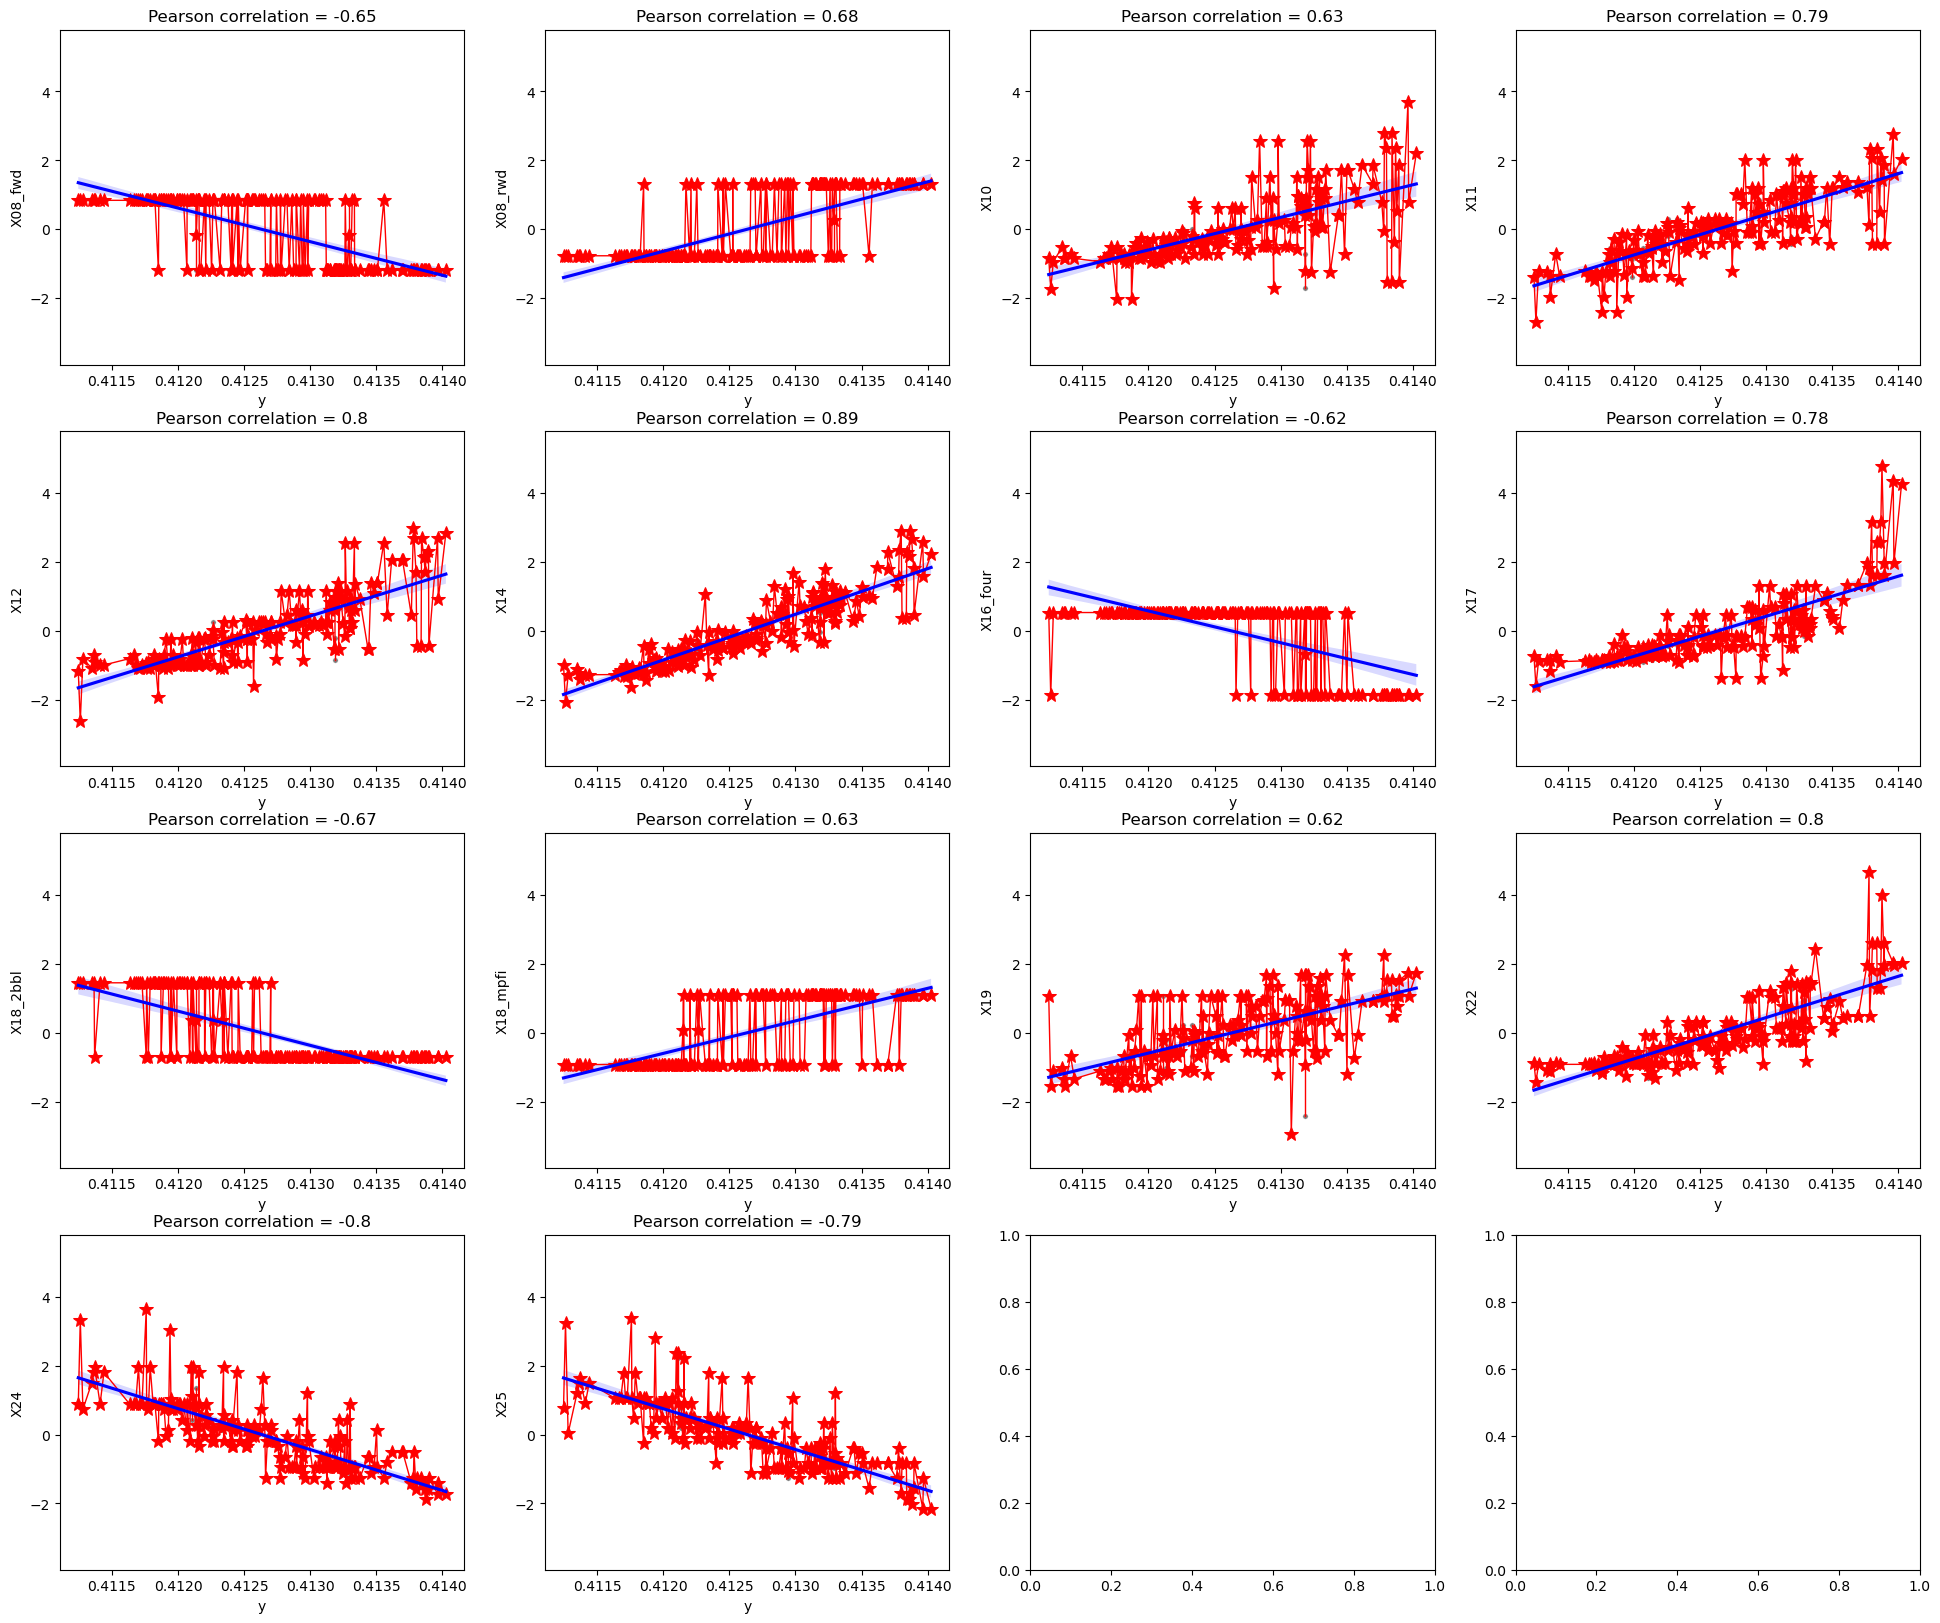

In [54]:
# check assumption 1: linear relationship (scatter)

# configure subplot
ncols = 4
nrows = np.ceil(len(X.columns) / ncols).astype('int')
fwidth = 6 * ncols
fheight = 5 * nrows
f1, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (fwidth, fheight))
axes = axes.reshape((nrows, ncols))

# configurations for individual plots
y_min = y.min() - 1
y_max = y.max() + 1
X_max = X.max().max() + 1
X_min = X.min().min() - 1

for i in range(len(X.columns)):
  col = X.columns[i]
  col_i = np.mod(i, ncols).astype('int')
  row_i = np.floor(i / ncols).astype('int')
  
  # plot scatter plots
  p1 = sns.scatterplot(ax = axes[row_i, col_i], y = X[col], x = y, marker = 'o',  s = 15, color = c1)
  
  # add main effects line
  p2 = sns.pointplot(ax = axes[row_i, col_i], y = X[col], x = y, native_scale=True, marker = '*', color = c2, linewidth = 1.0, markersize = 10)
  p2.set_ylim((X_min, X_max))
  
  # add regression line
  p3 = sns.regplot(ax = axes[row_i, col_i], y = X[col], x = y, marker = '', color = c3, ci = 95)
  
  # add correlation coefficient between X and y
  r_temp = r_include.iloc[i]
  txt  = f"Pearson correlation = {r_temp}"
  p3.set_title(txt)

plt.show()

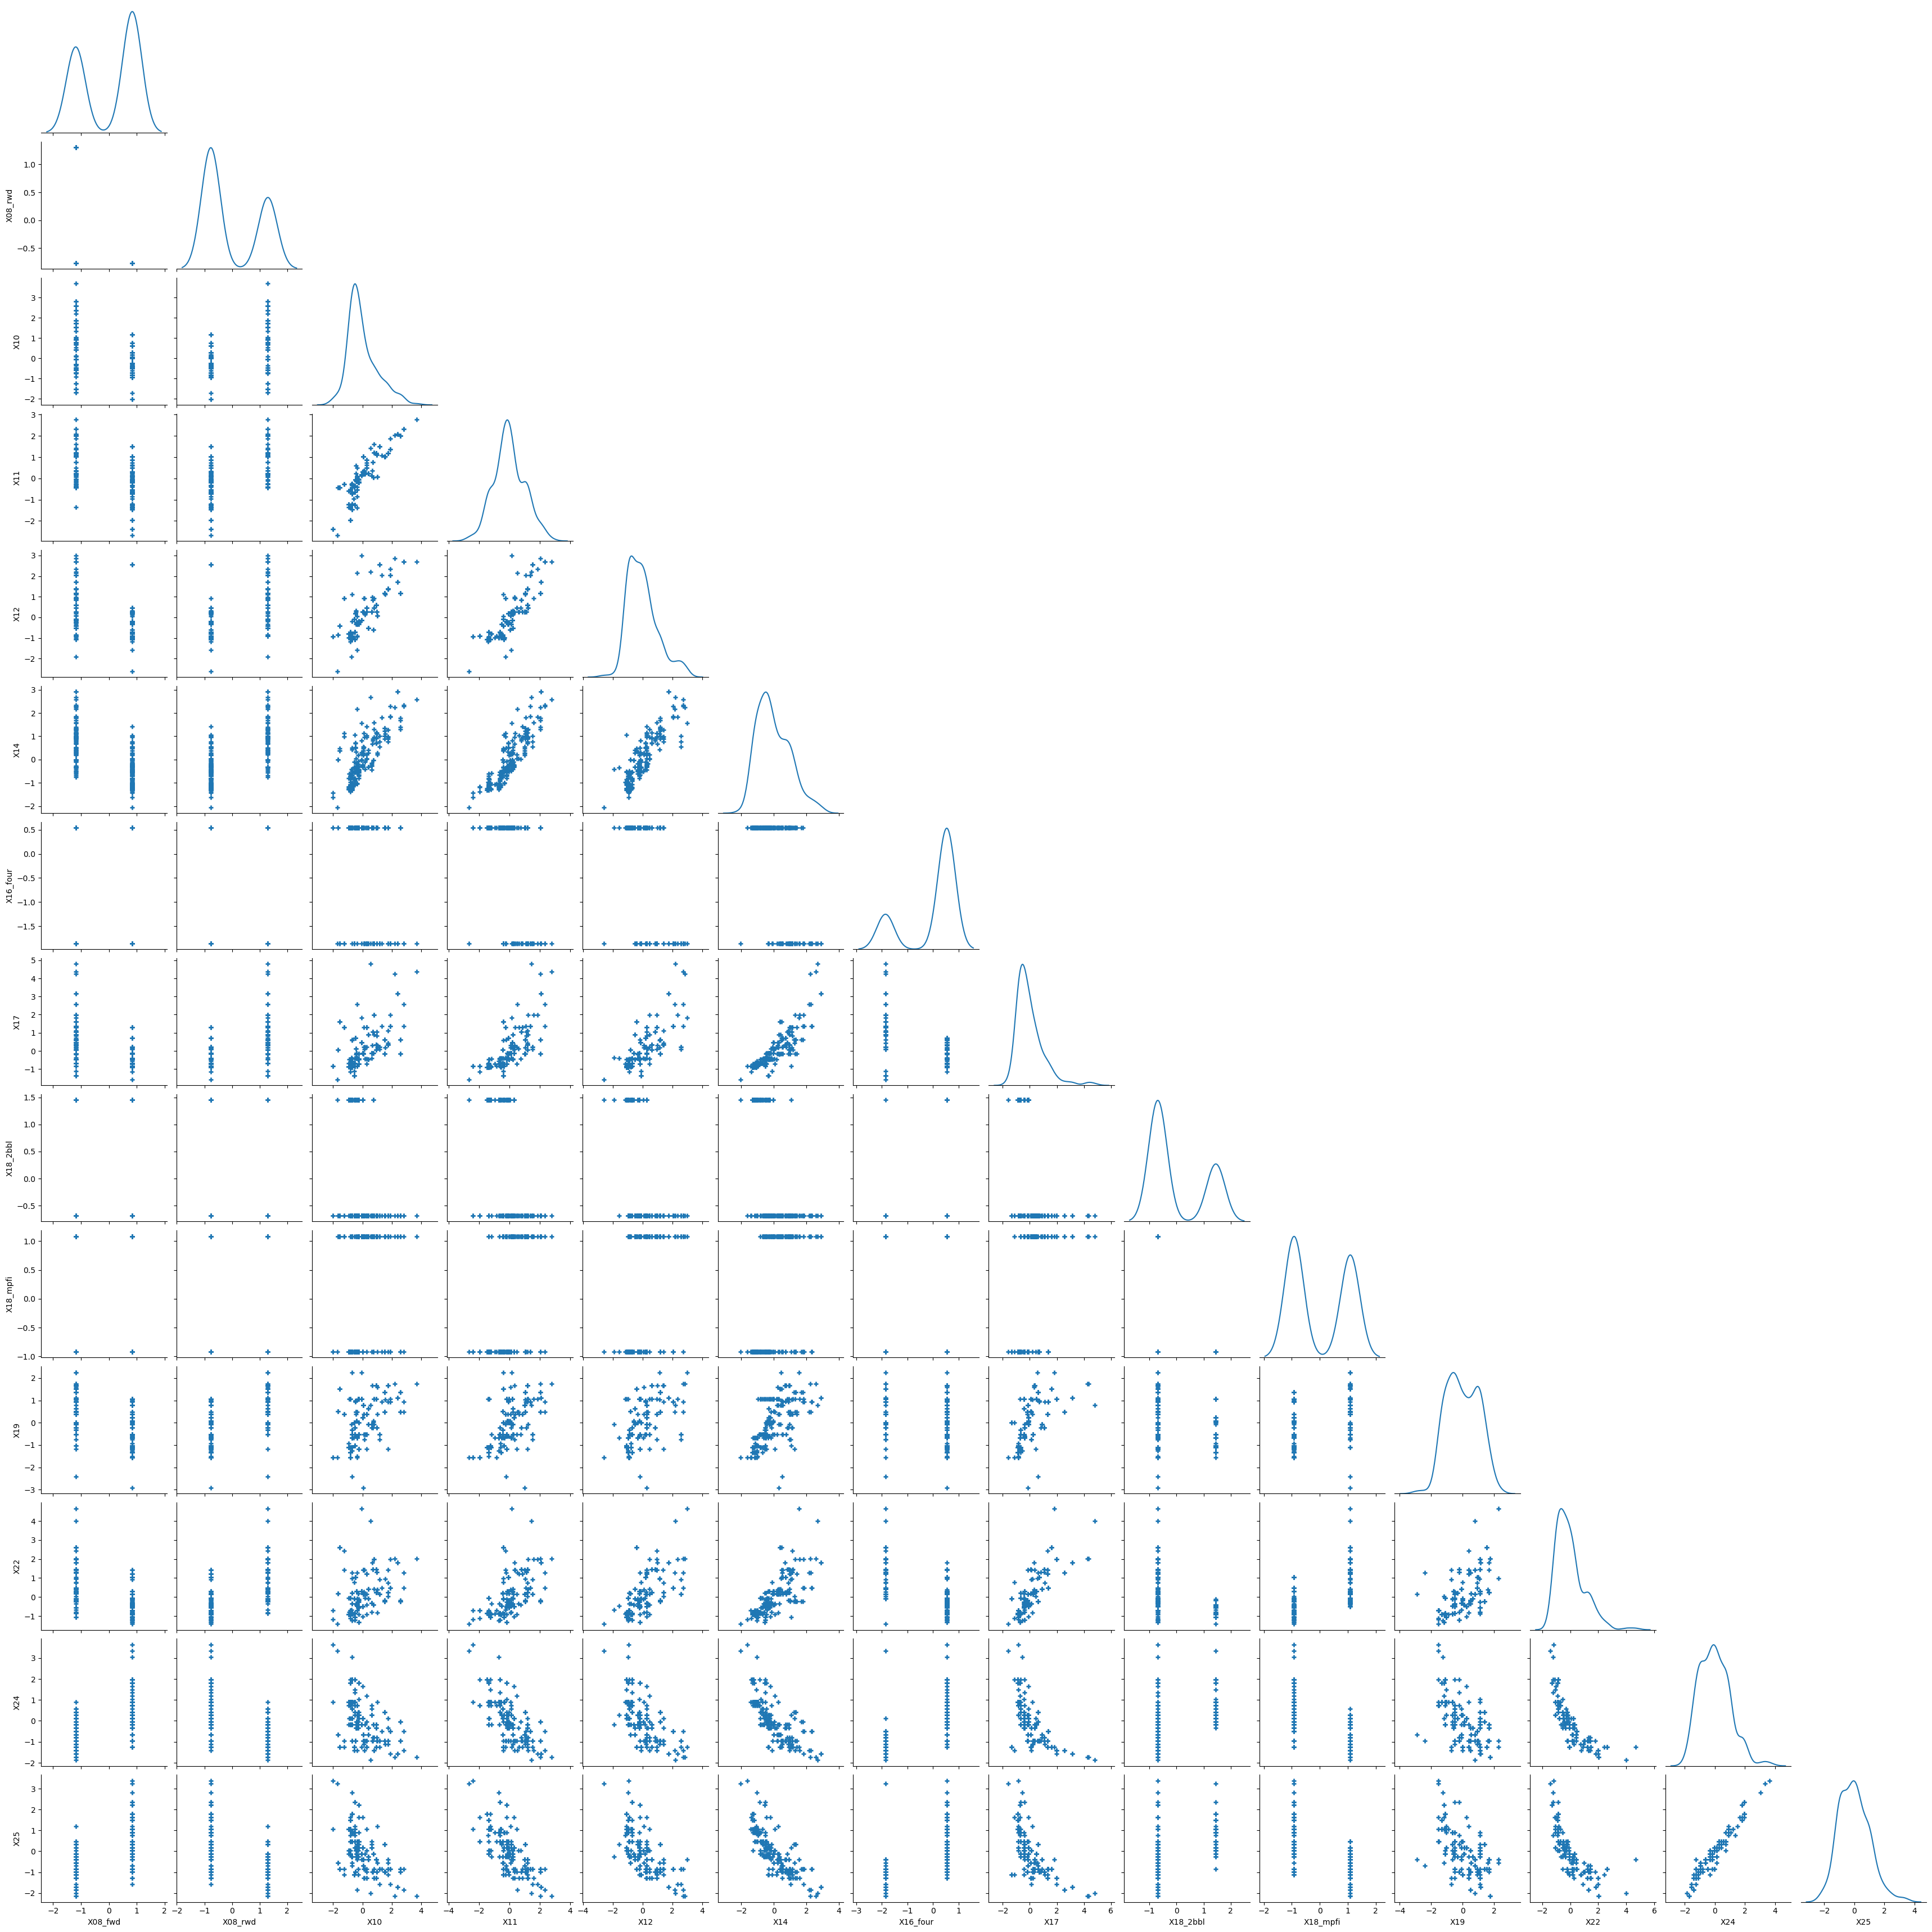

In [55]:
# check assumption 2: little or No Multi-Collinearity (approach 1)
p1 = sns.pairplot(data = X, corner = True, diag_kind="kde", diag_kws = dict(fill = False), plot_kws = dict(marker = "+", linewidth = 2))
plt.show()

In [56]:
# check assumption 2: little or No Multi-Collinearity (approach 2)
corr_threshold = 0.8
r = X.corr()
r.loc[:,:] = np.tril(r,0)
cond = np.where((abs(r) > corr_threshold) & (r != 1))
i = cond[0]
j = cond[1]
x_vars = r.index[i]
y_vars = r.columns[j]
r_values = [r.iloc[i[ii], j[ii]].round(2) for ii in range(len(i))]
check_vars = [(x_vars[i], y_vars[i], r_values[i]) for i in range(len(x_vars))]

# show highly correlated features
check_vars

[('X08_rwd', 'X08_fwd', -0.91),
 ('X11', 'X10', 0.87),
 ('X12', 'X11', 0.84),
 ('X14', 'X11', 0.88),
 ('X14', 'X12', 0.87),
 ('X17', 'X14', 0.85),
 ('X22', 'X17', 0.81),
 ('X24', 'X22', -0.8),
 ('X25', 'X24', 0.97)]

In [57]:
# check assumption 2: little or No Multi-Collinearity (approach 3)

# iterate removing high VIF Xs until all VIF values are less than threshold
X_temp = X.copy()
X_include = X.columns

# initialize check to see if vif requirements are statisfied
vif_good = 0
vif_threshold = 5
X_drop = list()

while vif_good == 0:
  # get vif values
  vif = [variance_inflation_factor(X_temp[X_include], i) for i in range(len(X_temp.columns))]
  max_vif = np.max(vif)
  
  # check if all vif values meet vif threshold
  if max_vif < vif_threshold:
    vif_good = 1
  else:
    cond1 = (vif == max_vif)
    X_include = X_include[~X_include.isin(X_include[cond1])]
    X_temp = X_temp[X_include]

# show final vif values
df_vif = pd.DataFrame({
  'X': X_include,
  'VIF': vif
})
df_vif = df_vif.sort_values(by = 'VIF', ascending = False)
df_vif

,X,VIF
2,X12,4.901743
4,X17,3.332498
1,X10,3.018458
8,X25,3.010138
7,X19,2.534670
3,X16_four,2.431909
6,X18_mpfi,2.071687
0,X08_fwd,2.055704
5,X18_2bbl,1.921290


In [58]:
# train test split data
X_train, X_test, y_train, y_test = train_test_split(X_temp, y,
 train_size = 0.7, 
 shuffle = True,
 random_state = random_state
)

In [59]:
# fit regression model
my_fit = LinearRegression()
temp = my_fit.fit(X_train, y_train)

In [60]:
# get predicted values
y_hat = my_fit.predict(X_test)

In [61]:
# residuals
e = y_test - y_hat

In [62]:
# evaluate regression model
explained_var = explained_variance_score(y_true = y_test, y_pred = y_hat)
rsquared = r2_score(y_true = y_test, y_pred = y_hat)
mse = mean_squared_error(y_true = y_test, y_pred = y_hat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true = y_test, y_pred = y_hat)
mdae = median_absolute_error(y_true = y_test, y_pred = y_hat)
temp = {
  'explained_var': [explained_var.round(2)],
  'rsquared': [rsquared.round(2)],
  'mse': [mse.round(2)],
  'rmse': [rmse.round(2)],
  'mae': [mae.round(2)],
  'mdae': [mdae.round(2)]
}
df_metrics = pd.DataFrame.from_dict(temp, orient = 'index', columns = ['values'])
df_metrics

,values
explained_var,0.87
rsquared,0.87
mse,0.00
rmse,0.00
mae,0.00
mdae,0.00


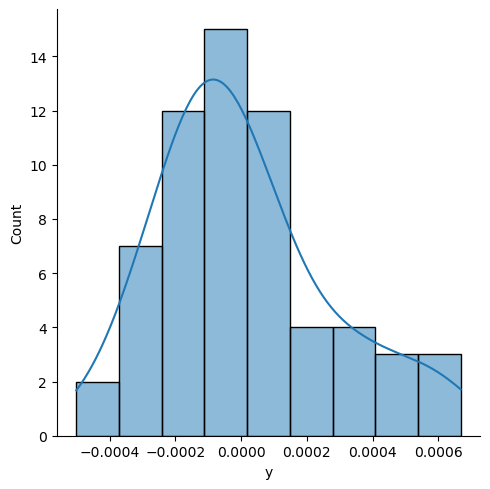

In [63]:
# check assumption 3: normality of residuals
p1 = sns.displot(data = e, kde = True)

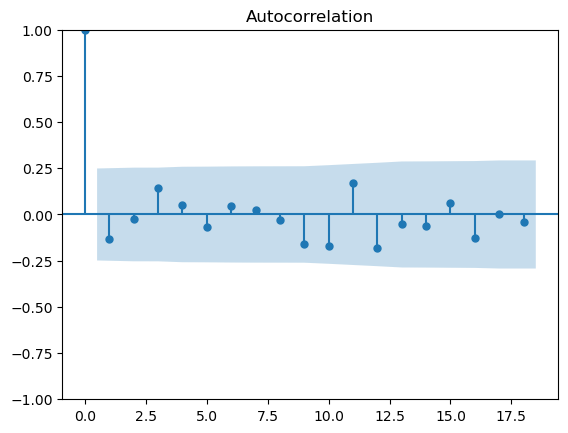

In [64]:
# check assumption 4: little or no autocorrelation
p1 = plot_acf(e)
plt.show()

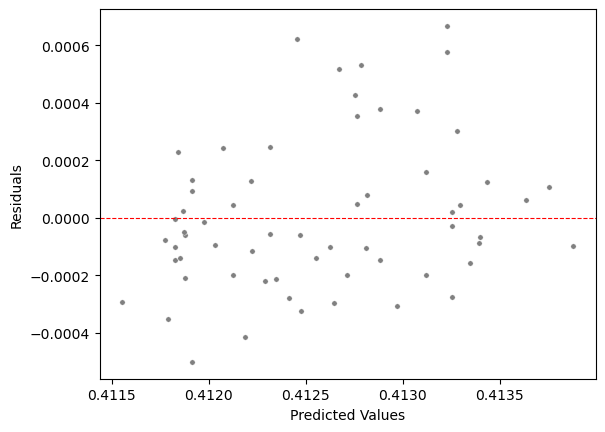

In [65]:
# check assumption 5: homoscedasticity (equal variance)
p1 = sns.scatterplot(y = e, x = y_hat, marker = 'o',  s = 15, color = c1)
p1.axhline(y = 0, linestyle = '--', linewidth = 0.8, color = c2)
plt.ylabel('Residuals')
plt.xlabel('Predicted Values')
plt.show()

In [66]:
# final regression model
intercept = my_fit.intercept_
coeffs = my_fit.coef_

temp = [ '(' + '{:0.3e}'.format(coeffs[i - 1]) + ') * ' + X_include[i - 1]  + '\n' for i in range(1, len(coeffs) + 1)]
part1 = '{:0.3e}'.format(intercept) + '\n'
part2 = ' + '.join(temp)

if lmbda != 0:
  print(f' y = ({part1} + {part2} + ) ^ {1 / lmbda}')
else:
  print(f' y = e ^ ({part1} + {part2})')

 y = (4.126e-01
 + (-7.402e-05) * X08_fwd
 + (3.923e-05) * X10
 + (1.609e-04) * X12
 + (-1.127e-04) * X16_four
 + (7.047e-05) * X17
 + (-1.467e-04) * X18_2bbl
 + (1.892e-05) * X18_mpfi
 + (8.296e-05) * X19
 + (-8.130e-05) * X25
 + ) ^ -2.0


In [37]:
y_true = y_test
y_pred = y_hat

In [123]:
# relative root mean squared error - relative/ratio error of model compared to naive/average model [0, Inf]
def jra_ml_rrmse(y_true, y_pred):
  a = y_pred - y_true
  b = np.power(a, 2).mean()
  c = np.sqrt(b)
  
  d = y_pred - np.mean(y_true)
  e = np.power(d, 2).mean()
  f = np.sqrt(e)
  
  x = c / f
  return(x)

# relative mean absolute error - relative/ratio error of model compared to naive/average model [0, Inf]
def jra_ml_rmae(y_true, y_pred):
  a = np.abs(y_pred - y_true)
  b = y_pred - np.mean(y_true)
  c = np.abs(b)
  x = (a.mean() / c.mean())
  return(x)

In [125]:
jra_ml_smape(y_true, y_pred)

0.0004945468948802442

In [126]:
# mean absolute percent error - goodness of fit; relative magnitue of error produced on average [0, Inf]
def jra_ml_mape(y_true, y_pred):
  a = np.abs(y_pred - y_true)
  b = a / np.abs(y_true) 
  x = b.mean() * 100
  return(x)
jra_ml_mape(y_true, y_pred)

0.04945468948802442